Kaggle competition - https://www.kaggle.com/competitions/kkbox-churn-prediction-challenge/overview

In [2]:
import warnings
warnings.filterwarnings('ignore') 

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!du -h data/*.csv


409M	data/members_v3.csv
41M	data/sample_submission_v2.csv
44M	data/train_v2.csv
111M	data/transactions_v2.csv
1,4G	data/user_logs_v2.csv


In [4]:
members_df = pd.read_csv("data/members_v3.csv")
train_df = pd.read_csv("data/train_v2.csv")
transcactions_df = pd.read_csv("data/transactions_v2.csv")
sample_submission = pd.read_csv("data/sample_submission_v2.csv")


## Initial Exploration

### Members table

In [4]:
sample_members_df = members_df.sample(frac=0.1)

In [5]:
members_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   msno                    6769473 non-null  object
 1   city                    6769473 non-null  int64 
 2   bd                      6769473 non-null  int64 
 3   gender                  2339968 non-null  object
 4   registered_via          6769473 non-null  int64 
 5   registration_init_time  6769473 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 309.9+ MB


In [6]:
members_df.head(4)

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915


In [7]:
members_df["gender"].value_counts()

gender
male      1195355
female    1144613
Name: count, dtype: int64

In [8]:
members_df["gender"].isna().mean()

0.6543352783887313

In [9]:

city_counts = members_df["city"].value_counts().reset_index()
city_counts["count"] /= members_df.shape[0] / 100
city_counts.columns = ["city", "count"]

Text(0, 0.5, '% of Members')

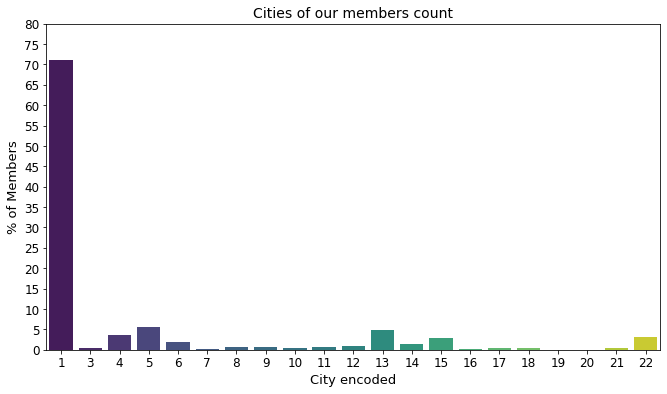

In [10]:


plt.figure(figsize=(11, 6))
sns.barplot(data=city_counts, x="city", y="count", palette="viridis")
plt.yticks(np.linspace(0, 80, 17), fontsize=12)
plt.xticks(fontsize=12)
plt.title("Cities of our members count", fontsize=14)
plt.xlabel("City encoded", fontsize=13)
plt.ylabel("% of Members", fontsize=13)


In [11]:
#age of the user

#drop_outliers
age_upper_bound = members_df["bd"].quantile(0.9995)
age_lower_bound = members_df["bd"].quantile(0.0005)

members_df = members_df[(members_df["bd"] > age_lower_bound) & (members_df["bd"] < age_upper_bound)]




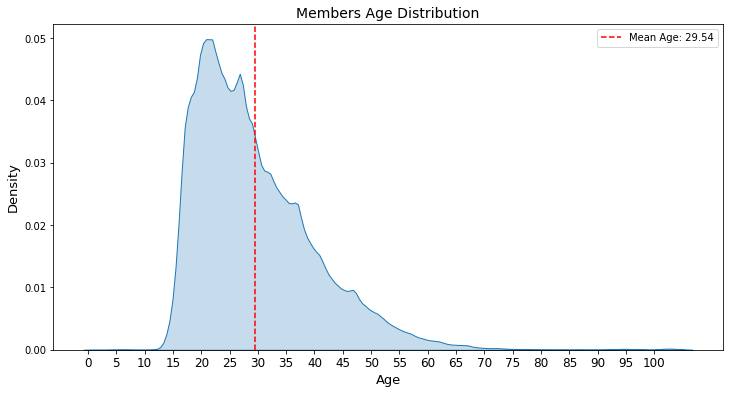

In [12]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=members_df, x='bd', fill=True)
plt.xlabel('Age', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title("Members Age Distribution", fontsize=14)
plt.xticks(np.linspace(0, 100, 21), fontsize=12)
plt.axvline(members_df["bd"].mean(), color='red', linestyle='--', label=f'Mean Age: {members_df["bd"].mean():.2f}')
plt.legend()

plt.show()

Text(0, 0.5, '% of Members')

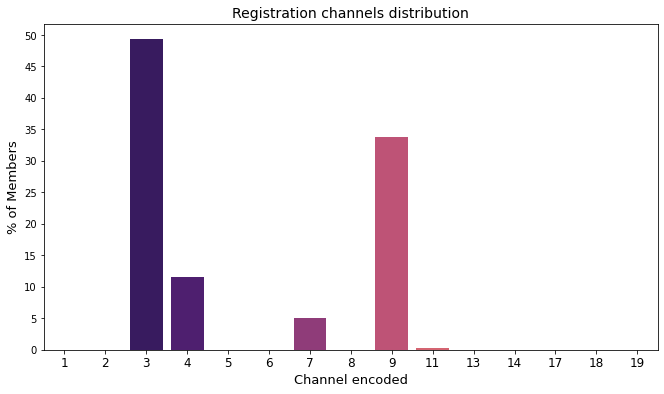

In [13]:
registr_channel_counts = members_df["registered_via"].value_counts().reset_index()
registr_channel_counts.columns = ["registered_via", "count"]

registr_channel_counts["count"] /= members_df.shape[0] / 100

plt.figure(figsize=(11, 6))
sns.barplot(data=registr_channel_counts, x="registered_via", y="count", palette="magma")
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0, 50, 11))
plt.title("Registration channels distribution", fontsize=14)
plt.xlabel("Channel encoded", fontsize=13)
plt.ylabel("% of Members", fontsize=13)


**Initial Obsevations**:
1) Timestamps are written as integer. We might want to convert it to datetime format
2) We have many unspecified genders, 65% of genders are NaNs
3) Most of members (70%) are coming from *City 1*
4) Age distribution is quite natural and nothing interesting noticed
5) There are 4 most common registration channels that our clients take. The rest are much less popular
    

### Train table (table with churn flags)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   msno      970960 non-null  object
 1   is_churn  970960 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


As this table only contains target, let's merge it with *members* table to observe patterns in churn

In [15]:
train_members_df = pd.merge(train_df, members_df, on="msno", how="left")

In [16]:
train_members_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    970960 non-null  object 
 1   is_churn                970960 non-null  int64  
 2   city                    386802 non-null  float64
 3   bd                      386802 non-null  float64
 4   gender                  377238 non-null  object 
 5   registered_via          386802 non-null  float64
 6   registration_init_time  386802 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 51.9+ MB


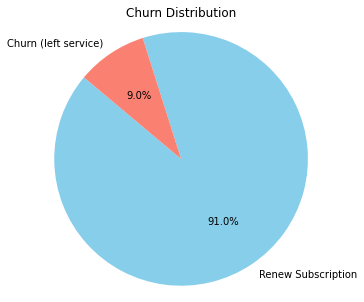

In [17]:
churn_counts = train_members_df['is_churn'].value_counts().reset_index()
churn_counts.columns = ['is_churn', 'count']

churn_counts['is_churn'] = churn_counts['is_churn'].replace({0: "Renew Subscription", 1: "Churn (left service)"})

plt.figure(figsize=(5, 5))
plt.pie(churn_counts['count'], labels=churn_counts['is_churn'], autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.axis('equal') 

plt.show()

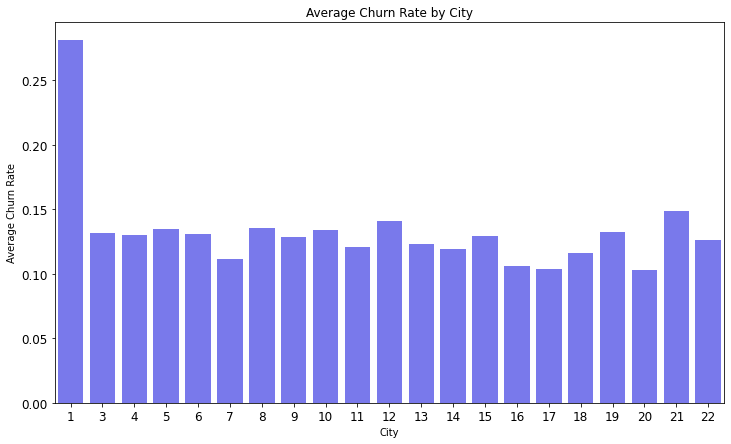

In [24]:
average_churn_by_city = train_members_df.groupby("city")["is_churn"].mean().reset_index()
average_churn_by_city['city'] = average_churn_by_city["city"].astype(int)


plt.figure(figsize=(12, 7))
sns.barplot(data=average_churn_by_city, x="city", y="is_churn", color="blue", alpha=0.6)
plt.xlabel('City')
plt.ylabel('Average Churn Rate')
plt.title('Average Churn Rate by City')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [31]:
avg_churn_by_gender = train_members_df.fillna("MISSING").groupby("gender")["is_churn"].mean().reset_index()

In [41]:
avg_churn_by_gender["is_churn"] *= 100

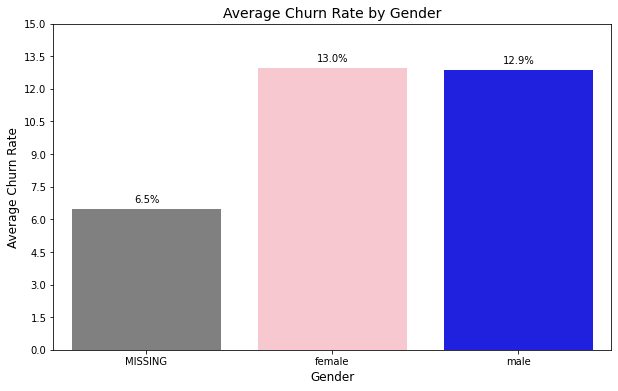

In [48]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=avg_churn_by_gender, x="gender", y="is_churn", palette=custom_palette)
plt.yticks(np.linspace(0, 15, 11))

# Step 3: Annotate each bar with its value
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Average Churn Rate', fontsize=12)
plt.title('Average Churn Rate by Gender', fontsize=14)
plt.show()

In [76]:
bins = [0, 18, 25, 35, 45, 55, 65, 100, np.nan]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+', "MISSING"]
train_members_df['age_bin'] = pd.cut(train_members_df['bd'], bins=bins, labels=labels, right=True)
train_members_df["age_bin"] = train_members_df["age_bin"].fillna("MISSING")


avg_churn_by_age = train_members_df.groupby("age_bin")["is_churn"].mean().reset_index()
avg_churn_by_age["is_churn"] *= 100

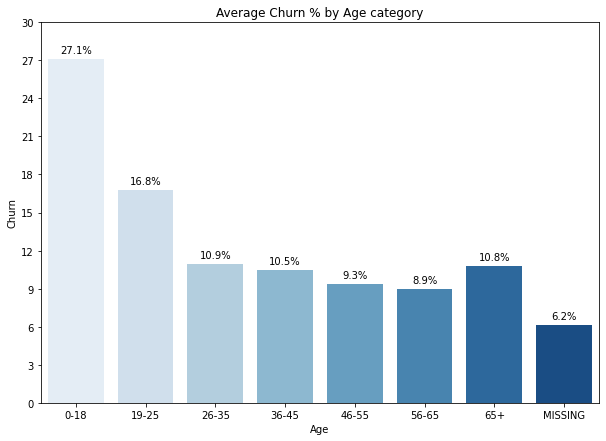

In [83]:
plt.figure(figsize=(10, 7))
barplot = sns.barplot(data=avg_churn_by_age, x='age_bin', y='is_churn', palette="Blues")
plt.yticks(np.linspace(0, 30, 11))
plt.title("Average Churn % by Age category")
plt.xlabel("Age")
plt.ylabel("Churn")

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9), textcoords='offset points')


plt.show()

In [6]:
transcactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   msno                    1431009 non-null  object
 1   payment_method_id       1431009 non-null  int64 
 2   payment_plan_days       1431009 non-null  int64 
 3   plan_list_price         1431009 non-null  int64 
 4   actual_amount_paid      1431009 non-null  int64 
 5   is_auto_renew           1431009 non-null  int64 
 6   transaction_date        1431009 non-null  int64 
 7   membership_expire_date  1431009 non-null  int64 
 8   is_cancel               1431009 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 98.3+ MB


In [9]:
user_logs_df = pd.read_csv("data/user_logs_v2.csv", nrows=100_000)

user_logs_df.to_csv("data/user_logs_v2_sample.csv", index=False)

In [8]:
user_logs_df.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558
